In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import os 
import sys 
import pickle
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
root_path = os.path.realpath('../')
sys.path.append(root_path)


from utils.parser import parse_alldata
from utils.analysis import print_testacc, print_ttest_acc, compute_choicemats, fit_sigmoids_to_choices, gen_choicemodelrdms, stats_fit_choicerdms,fit_model_to_subjects
from utils.plotting import disp_accuracy, disp_lcurves, disp_sigmoid_fits, disp_param_estimates, disp_choicemats, disp_rsa_param_estimates, disp_model_estimates


## Parameters

In [2]:
# set a few parameters 
%matplotlib inline
working_dir = os.getcwd()
data_dir = working_dir + "/../data/animals_vehicles_1_base/"

domains = ['animals','vehicles']
curricula = ['blocked','interleaved']


# Data Import

In [3]:
# parse data 
try:
    with open(data_dir+"parsed/"+"animals_vehicles_pilot.pkl","rb") as f:
        alldata = pickle.load(f)
except FileNotFoundError:
    alldata = parse_alldata(data_dir+"raw/")
    from utils.parser import boundary_to_nan
    alldata = boundary_to_nan(alldata)
    with open(data_dir+"parsed/"+"animals_vehicles_pilot.pkl","wb") as f:
        pickle.dump(alldata,f)
    


In [15]:
import numpy as np
genders = {}
ages = []
domains = ["animals", "vehicles"]
curricula = ["blocked", "interleaved"]
for dom in domains:
    for cur in curricula:
        for age in alldata[dom][cur]["participant_age"]:
            if age == "21-30":
                age = 25
            elif age == "31-40":
                age = 35
            elif age == "18-20":
                age = 19
            else:
                age = np.nan
            ages.append(age)
        for gender in alldata[dom][cur]["participant_sex"]:
            if gender in genders:
                genders[gender] +=1
            else:
                genders[gender] = 1

print(f", n = {len(ages)}, average age: {np.nanmean(ages)}")
print(genders)


, n = 400, average age: 26.914786967418546
{'female': 264, 'male': 130, 'other': 5, 'pref_not_say': 1}


In [14]:
import numpy as np


[25,
 25,
 19,
 25,
 35,
 35,
 25,
 25,
 35,
 25,
 19,
 25,
 35,
 19,
 19,
 19,
 25,
 19,
 19,
 25,
 35,
 35,
 19,
 25,
 25,
 25,
 25,
 25,
 25,
 25,
 19,
 25,
 35,
 25,
 19,
 25,
 35,
 35,
 35,
 19,
 25,
 19,
 35,
 25,
 35,
 25,
 25,
 25,
 35,
 35,
 19,
 25,
 25,
 35,
 25,
 35,
 25,
 25,
 35,
 25,
 19,
 35,
 19,
 25,
 35,
 25,
 25,
 25,
 25,
 35,
 25,
 19,
 25,
 35,
 35,
 35,
 35,
 35,
 25,
 25,
 19,
 25,
 35,
 25,
 35,
 35,
 19,
 35,
 19,
 35,
 25,
 35,
 25,
 19,
 35,
 35,
 25,
 25,
 25,
 19,
 19,
 25,
 25,
 19,
 25,
 35,
 35,
 35,
 35,
 25,
 25,
 35,
 35,
 25,
 25,
 25,
 19,
 25,
 25,
 25,
 25,
 25,
 35,
 19,
 25,
 19,
 25,
 25,
 19,
 19,
 25,
 25,
 35,
 25,
 35,
 25,
 35,
 25,
 19,
 25,
 25,
 19,
 25,
 35,
 35,
 25,
 25,
 35,
 19,
 35,
 25,
 35,
 19,
 35,
 25,
 35,
 35,
 19,
 35,
 35,
 35,
 35,
 25,
 19,
 25,
 25,
 35,
 25,
 25,
 25,
 35,
 25,
 25,
 25,
 19,
 25,
 25,
 35,
 35,
 19,
 25,
 25,
 35,
 35,
 25,
 25,
 35,
 19,
 25,
 25,
 25,
 19,
 19,
 25,
 19,
 25,
 25,
 25,
 25,
 19,


# Analysis

## Accuracy

In [4]:
# if desired, kick out bad subjects based on training performance
from copy import deepcopy
goodData = deepcopy(alldata)
doms = ["animals","vehicles"]
curricula = ["blocked","interleaved"]
for d in doms:
    for c in curricula:
        badsubs = np.nanmean(goodData[d][c]["resp_correct"][:,:400], 1) <0.5 # training auccuracy below 55 % 
        
        for k, v in goodData[d][c].items():
            goodData[d][c][k] = list(np.array(v)[badsubs==False]) if type(v)==list else v[badsubs==False]

alldata =goodData

### calculate accuracy and test for between group differences

In [5]:

print_testacc(alldata,onlygood=True, whichtask="base")
print_ttest_acc(alldata, onlygood=True, whichtask="base")
print('\n')


** Accuracy on base task **
only good subjects (n=89): animals, blocked: 0.80
only good subjects (n=88): animals, interleaved: 0.77
only good subjects (n=93): vehicles, blocked: 0.83
only good subjects (n=90): vehicles, interleaved: 0.84
** mann whitney u on base task **
only good subjects: animals, blocked vs interleaved: t(177)= 1.271  p= 0.205
only good subjects: vehicles, blocked vs interleaved: t(183)= -0.189  p= 0.850




In [81]:
# plot test accuracy
disp_accuracy(alldata,'animals')
disp_accuracy(alldata,'vehicles')
        


In [22]:
f = plt.gcf()
f.get_size_inches()

array([6., 4.])

<Figure size 432x288 with 0 Axes>

In [82]:
# learning curves
disp_lcurves(alldata)



## Choice Patterns

In [6]:
choicemats = compute_choicemats(alldata)

### display sigmoids for rel and irrel dimensions 

(2, 89, 5)
(2, 88, 5)
(2, 93, 5)
(2, 90, 5)


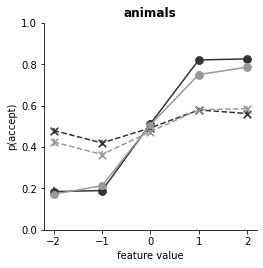

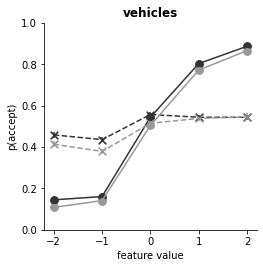

In [7]:
betas = fit_sigmoids_to_choices(choicemats,onlygood=True,fitlapse=False)
disp_sigmoid_fits(choicemats,betas, onlygood=True)

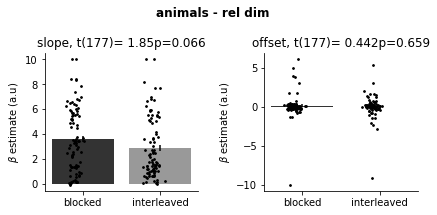

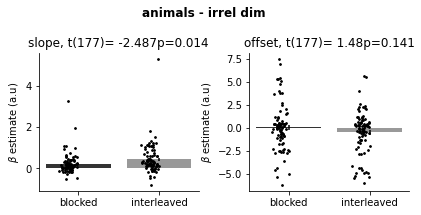

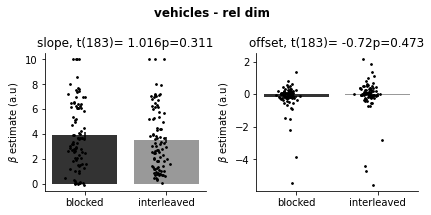

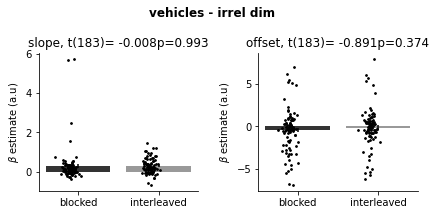

In [10]:
# stats on estimated slopes
%matplotlib inline
disp_param_estimates(betas,onlygood=True)

### display full choice matrices

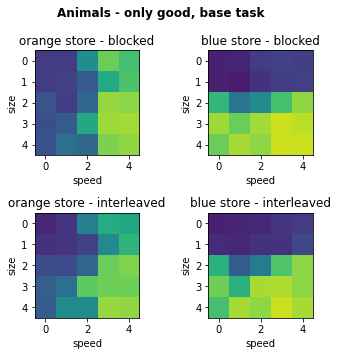

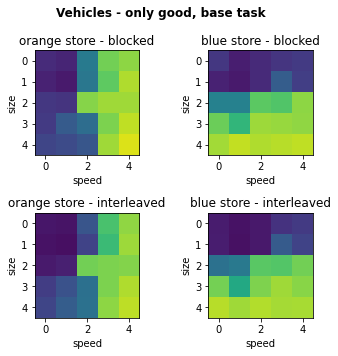

In [11]:
disp_choicemats(choicemats,onlygood=True)

## Choice Pattern RSA


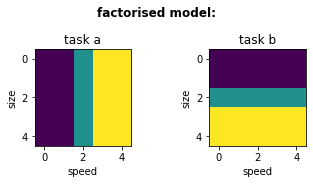

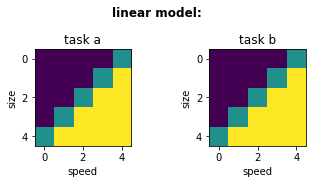

In [57]:
_ = gen_choicemodelrdms(monitor=True)

In [13]:
%matplotlib qt
betas = stats_fit_choicerdms(choicemats,onlygood=True)
disp_rsa_param_estimates(betas,onlygood=True)

(89, 1)
(89, 1)
(93, 1)
(93, 1)


## Choice Model


In [ ]:
thetas = fit_model_to_subjects(choicemats,onlygood=True,n_runs=50)

In [87]:
# stats on estimated slopes
disp_model_estimates(thetas)